## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the brain tumor dataset

In [2]:
dataset_directory_location = 'data'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['cloudy', 'desert', 'green_area', 'water']

In [6]:
os.listdir(test_dataset_location)

['cloudy', 'desert', 'green_area', 'water']

## Viewing a brain image

In [7]:
satellite_img_cloudy = os.path.join(train_dataset_location, 'cloudy')

In [8]:
os.listdir(satellite_img_cloudy)[:1]

['train_10021.jpg']

In [9]:
satellite_img_cloudy_read = imread(os.path.join(satellite_img_cloudy, 'train_10021.jpg'))

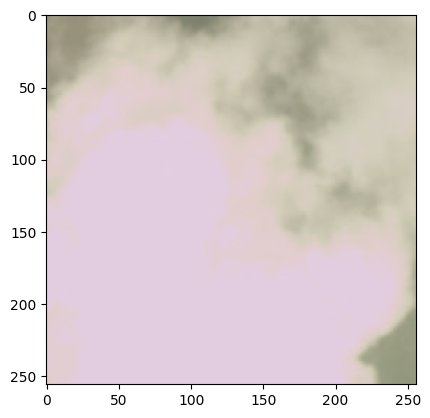

In [10]:
plt.imshow(satellite_img_cloudy_read)

In [11]:
satellite_img_cloudy_read.shape 

(256, 256, 4)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               rescale=1./255)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


## Defining the early stop

In [15]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [16]:
model = Sequential()

In [17]:
get_mobilenet_v3_pretrained_model = "https://www.kaggle.com/models/google/mobilenet-v3/frameworks/TensorFlow2/variations/small-075-224-classification/versions/1"

In [18]:
mobilenet_v3_pretrained_model = hub.KerasLayer(get_mobilenet_v3_pretrained_model, input_shape=correct_image_shape, trainable=False) 

In [19]:
model.add(mobilenet_v3_pretrained_model)

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              2052577   
                                                                 
 batch_normalization (BatchN  (None, 1001)             4004      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4

In [21]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [22]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=30, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/30
250/250 [==============================] - 88s 247ms/step - loss: 1.7998 - accuracy: 0.3355 - val_loss: 1.0541 - val_accuracy: 0.5525
Epoch 2/30
250/250 [==============================] - 58s 232ms/step - loss: 1.1484 - accuracy: 0.5583 - val_loss: 0.7422 - val_accuracy: 0.6875
Epoch 3/30
250/250 [==============================] - 58s 231ms/step - loss: 0.8588 - accuracy: 0.6735 - val_loss: 0.6107 - val_accuracy: 0.7475
Epoch 4/30
250/250 [==============================] - 57s 228ms/step - loss: 0.7015 - accuracy: 0.7423 - val_loss: 0.4801 - val_accuracy: 0.8075
Epoch 5/30
250/250 [==============================] - 57s 229ms/step - loss: 0.5977 - accuracy: 0.7822 - val_loss: 0.4166 - val_accuracy: 0.8750
Epoch 6/30
250/250 [==============================] - 57s 229ms/step - loss: 0.5588 - accuracy: 0.7912 - val_loss: 0.3640 - val_accuracy: 0.8825
Epoch 7/30
250/250 [==============================] - 57s 229ms/step - loss: 0.4902 - accuracy: 0.8273 - val_loss: 0.3052 - val_ac

In [23]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

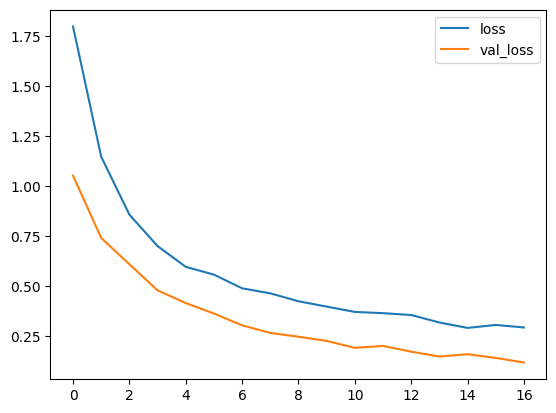

In [24]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

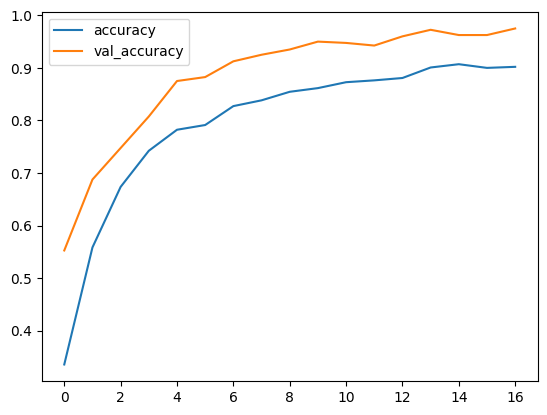

In [25]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [26]:
model.evaluate(train_image_gen)[1]

250/250 [==============================] - 53s 210ms/step - loss: 0.0984 - accuracy: 0.9795


0.9794999957084656

In [27]:
model.evaluate(test_image_gen)[1]

25/25 [==============================] - 5s 208ms/step - loss: 0.1199 - accuracy: 0.9775


0.9775000214576721

## Predicting on a sample image

In [28]:
sample_img_load = image.load_img('./data/test/desert/desert(1003).jpg', target_size=correct_image_shape)

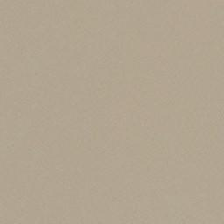

In [29]:
sample_img_load

In [30]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [31]:
sample_img_to_arr = image.img_to_array(sample_img_load) / 255

In [32]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [33]:
prediction = model.predict(sample_img_to_arr_expand_dim)[0]

1/1 [==============================] - 2s 2s/step


In [34]:
pred_result = np.argmax(prediction)

In [35]:
class_names = ['cloudy', 'desert', 'green_area', 'water']

In [36]:
pred_final_result = class_names[pred_result]

In [37]:
pred_final_result

'desert'

## Save the model

In [38]:
save_model(model, 'mobilenetV3_model')

INFO:tensorflow:Assets written to: mobilenetV3_model\assets


INFO:tensorflow:Assets written to: mobilenetV3_model\assets
